In [1]:
import xarray as xr
import numpy
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import scipy.io
import math
import json


Use ncclimo to generate regridded monthly time series for T, CLDICE, CLDLIQ and LANDFRAC needed for this analysis. Additionally, Z3, CLD_CAL_ICE and CLD_CAL_LIQ are needed for COSP based comparison.  


conda activate e2c_nco511_13
cd /p/user_pub/work/E3SM/2_0/historical/LR/atmos/native/model-output/mon/ens1/v20220806
eval ls v2.LR.historical_0101.eam.h0.*{1985..2014}*.nc | ncclimo -P eam --caseid=v2.LR.historical_0101 --var=T,CLDICE,CLDLIQ,LANDFRAC,Z3,CLD_CAL_ICE,CLD_CAL_LIQ --yr_srt=1985 --yr_end=2014 --drc_out=/p/user_pub/e3sm/zhang40/COSP_phase_data -O /p/user_pub/e3sm/zhang40/COSP_phase_data/data --map=/p/user_pub/e3sm/staging/resource/maps/map_ne30pg2_to_cmip6_180x360_aave.20200201.nc --split


In [2]:
def flatten_array(var):
    var_1d = var.stack(stacked=[...]).values
    var_1d = var_1d[~numpy.isnan(var_1d)]
    return var_1d

In [3]:
def compute_lcf(cice, cliq, temp, landfrac):
    metrics_dict = {}
    ctot = cice + cliq
    #ctot_sel = ctot.where((temp >= 220) & (temp <= 280)).where(ctot > 1e-9).where(landfrac==0)
    ctot_sel = ctot.where((temp >= 220) & (temp <= 280)).where(ctot > 1e-3).where(landfrac==0)
    cliq_sel = cliq.where(ctot_sel.notnull())
    temp_sel = temp.where(ctot_sel.notnull())
    
    ctot_1d = flatten_array(ctot_sel)
    cliq_1d = flatten_array(cliq_sel)
    temp_1d = flatten_array(temp_sel)
    print(temp_1d,ctot_1d,cliq_1d)
    
    lcf = cliq_1d/ctot_1d
    
    mean_stat = binned_statistic(temp_1d, lcf, 
                             statistic='mean', 
                             bins=20, 
                             range=(220, 280))
    
    temp_bin_center = (mean_stat.bin_edges[:-1] + mean_stat.bin_edges[1:]) / 2
    
    return temp_bin_center, mean_stat.statistic

In [4]:
#datapath = '/p/user_pub/e3sm/zhang40/COSP_phase_data/data'
#landfrac = xr.open_dataset(f'{datapath}/LANDFRAC_198501_201412.nc').sel(lat=slice(-70,-30))['LANDFRAC']
#temp = xr.open_dataset(f'{datapath}/T_198501_201412.nc').sel(lat=slice(-70,-30))['T']
#cice = xr.open_dataset(f'{datapath}/CLDICE_198501_201412.nc').sel(lat=slice(-70,-30))['CLDICE']
#cliq = xr.open_dataset(f'{datapath}/CLDLIQ_198501_201412.nc').sel(lat=slice(-70,-30))['CLDLIQ']

In [5]:
datapath = '/Users/zhang40/Documents/e3sm_diags_data/e3sm_diags_test_data/E3SM_v2'
landfrac = xr.open_dataset(f'{datapath}/LANDFRAC_200001_200012.nc').sel(lat=slice(-70,-30))['LANDFRAC']
temp = xr.open_dataset(f'{datapath}/T_200001_200012.nc').sel(lat=slice(-70,-30))['T']
z3 = xr.open_dataset(f'{datapath}/Z3_200001_200012.nc').sel(lat=slice(-70,-30))['Z3']
cice = xr.open_dataset(f'{datapath}/CLD_CAL_ICE_200001_200012.nc').sel(lat=slice(-70,-30))['CLD_CAL_ICE']
cliq = xr.open_dataset(f'{datapath}/CLD_CAL_LIQ_200001_200012.nc').sel(lat=slice(-70,-30))['CLD_CAL_LIQ']

In [6]:
cosp_ht = cice.cosp_ht

In [7]:
def find_nearest(array, value):
    array = numpy.asarray(array)
    idx = (numpy.abs(array - value)).argmin()
    #print('return2',array[idx],idx)
    return array[idx],idx


In [8]:
temp_ht = cice.copy()
temp_ht.values = numpy.full_like(cice, numpy.nan)
for time_id in range(0,1):#(temp.time.shape[0]):
    for lat_id in range(temp.lat.shape[0]):     
        for lon_id in range(temp.lon.shape[0]): 
            # find columns has ice+liquid > minimal:
            #if any(i>0.1 for i in (cice[time_id, :, lat_id, lon_id]+cliq[time_id, :, lat_id, lon_id]).values):
                array_z = z3[time_id, :, lat_id, lon_id].values
                #z_ind = round(fix(array_z-240/480),0)
                for ht_id,ht in enumerate(cosp_ht.values):
                    z_value,z_ind = find_nearest(array_z,ht)
                    temp_ht[time_id,ht_id,lat_id,lon_id] = temp[time_id,z_ind,lat_id,lon_id]
print(temp_ht)
            

<xarray.DataArray 'CLD_CAL_ICE' (time: 12, cosp_ht: 40, lat: 40, lon: 360)>
array([[[[230.73866, 230.73866, 230.73866, ..., 230.6275 , 230.6275 ,
          230.6275 ],
         [230.31657, 230.31898, 230.32382, ..., 230.21654, 230.21175,
          230.20935],
         [230.10616, 230.10873, 230.11388, ..., 230.00616, 230.00099,
          229.99841],
         ...,
         [203.33086, 203.25377, 203.18822, ..., 203.55576, 203.4971 ,
          203.44946],
         [202.66304, 202.57622, 202.50009, ..., 202.922  , 202.85803,
          202.80373],
         [201.99644, 201.89026, 201.78395, ..., 202.264  , 202.2116 ,
          202.15923]],

        [[229.91357, 229.91357, 229.91357, ..., 229.78201, 229.78201,
          229.78201],
         [229.54233, 229.54445, 229.5487 , ..., 229.41011, 229.40578,
          229.40361],
         [229.35715, 229.3594 , 229.36394, ..., 229.22461, 229.22006,
          229.21779],
...
         [      nan,       nan,       nan, ...,       nan,       nan,
      

In [9]:
temp_ht.name = 'CLD_CAL_T'

In [10]:
metrics_dict = {}
metrics_dict['test'] = {}
#metrics_dict['test']['T'], metrics_dict['test']['LCF']  = compute_lcf(cice, cliq, temp, landfrac)
metrics_dict['test']['T'], metrics_dict['test']['LCF']  = compute_lcf(cice[0,], cliq[0,], temp_ht[0,], landfrac[0,])

[221.16576 224.33498 227.78949 ... 251.12431 274.90274 277.44553] [5.953258   7.686194   9.724174   ... 0.4032258  0.24193548 0.24193548] [0.         0.         0.         ... 0.         0.         0.24193548]


In [11]:
# add reference data from Hu et al. 2010
obs = []
for ibin, temp in enumerate(metrics_dict['test']['T']):
    temp = temp - 273.15
    pt=7.6725+1.0118*temp+0.1422*(temp**2)+0.0106*(temp**3)+3.39*1e-4*(temp**4)+3.95*1e-6*(temp**5)
    lcf = 1./(1.+math.exp(-1.*pt))
    obs.append(lcf)
metrics_dict['obs'] = {"T": metrics_dict['test']['T'],"LCF":obs}

In [12]:
# add CMIP results from McCoy et al. 2015 and 2016
datapath = '/Users/zhang40/Documents/ACME/COSP_phase_diags'
cmip5 = scipy.io.loadmat(f'{datapath}/obs/SCL_T5050_30S_70S.mat')
cmip5_data = {}

for imod in range(len(cmip5['MODEL'][:])):
    model_name = cmip5['MODEL'][imod][0][0]
    cmip5_data[model_name]={}
    cmip5_data[model_name]['T']=cmip5['T'][imod][0].flatten()
    cmip5_data[model_name]['LCF']=cmip5['SCL'][imod][0].flatten()

metrics_dict['cmip5'] = cmip5_data


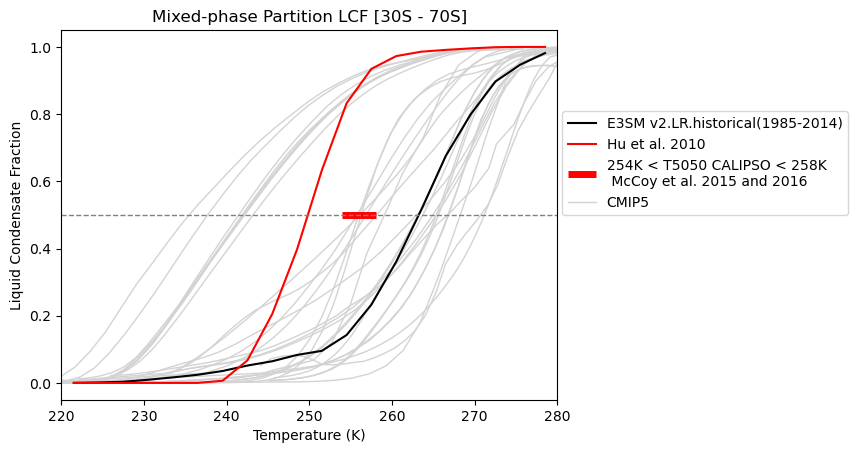

In [27]:
fig, ax = plt.subplots()

ax.plot(metrics_dict['test']['T'], metrics_dict['test']['LCF'], color = 'black', label='E3SM v2.LR.historical(1985-2014)', zorder = 1)
ax.plot(metrics_dict['obs']['T'], metrics_dict['obs']['LCF'], color = 'red', label='Hu et al. 2010', zorder = 2)
ax.hlines(y=0.5, xmin=254, xmax=258, linewidth=5, color='r', label='254K < T5050 CALIPSO < 258K \n McCoy et al. 2015 and 2016')

for idx, imod in enumerate(list(metrics_dict['cmip5'].keys())):
    cmip5 = metrics_dict['cmip5']
    if idx == 0:
        ax.plot(cmip5[imod]['T'], cmip5[imod]['LCF'], linewidth=1, color = 'lightgrey', label='CMIP5', zorder = -1)
    else:
        ax.plot(cmip5[imod]['T'], cmip5[imod]['LCF'], linewidth=1, color = 'lightgrey', zorder = -1)#, label=cmip5['MODEL'][imod][0][0])

ax.hlines(y=0.5, xmin=220, xmax=280, linewidth=1, linestyles='--', color='grey')
ax.set_ylabel('Liquid Condensate Fraction')
ax.set_xlim(220,280)
ax.set_xlabel('Temperature (K)')
ax.legend(loc='upper right', bbox_to_anchor=(1.6, 0.8))
ax.set_title('Mixed-phase Partition LCF [30S - 70S]')
plt.show()

In [9]:
# Save reference data as a json file
metrics_dict['E3SM.v2.LR.historical']={}
metrics_dict['E3SM.v2.LR.historical']['T'] = metrics_dict['test']['T']
metrics_dict['E3SM.v2.LR.historical']['LCF'] = metrics_dict['test']['LCF']

del metrics_dict['test']
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

with open(f'{datapath}/mixed-phase_partition_data_1985-2014.json', 'w') as fp:
    json.dump(metrics_dict, fp, cls = NumpyEncoder)

In [10]:
# Read reference data back in
with open(f'{datapath}/mixed-phase_partition_data_1985-2014.json', 'r') as myfile:
    lcf_file=myfile.read()

# parse file
lcf_data = json.loads(lcf_file)